In [2]:
import json
import math
import os
import pickle
import random
from tqdm import tqdm

import anndata
import numpy as np
import pandas
import safetensors
import scanpy as sc
import scvi
import torch
from scvi.distributions import ZeroInflatedNegativeBinomial
from torch import nn
from torch.distributions import Normal
from datasets import load_from_disk
from transformers import AutoTokenizer, AutoModelForCausalLM, GPTNeoXForCausalLM, GPTNeoXConfig

import umap
from sklearn.decomposition import PCA
from scipy.sparse import issparse
from umap import UMAP
import matplotlib.pyplot as plt

from utils.combo_split import combo_split_nochron
from utils.modules import CustomDecoder, CustomVAEDecoder

# Load data

In [3]:
adata_file_path = "/home/dfl32/project/ifm/cinemaot_data/hvg_normalized_cinemaot_768.h5ad"
adata = sc.read_h5ad(adata_file_path)

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
def generate_bimodal_samples(num_samples):
    # Define the means for the two modes
    num_samples_mode = num_samples // 2
    mean1 = torch.tensor([[-2.0, -2.0]]*num_samples_mode)
    mean2 = torch.tensor([[2.0, 2.0]]*num_samples_mode)

    # Standard deviation for both modes (standard normal)
    std = torch.tensor([[1.0, 1.0]]*num_samples_mode)

    # Half samples from each mode
    num_samples_mode = num_samples // 2

    # Generate samples for each mode
    samples_mode1 = torch.normal(mean1, std)
    samples_mode2 = torch.normal(mean2, std)

    # Concatenate samples from both modes
    samples = torch.cat((samples_mode1, samples_mode2), dim=0)

    # Shuffle the samples to mix modes
    indices = torch.randperm(num_samples)
    shuffled_samples = samples[indices]

    return shuffled_samples

# Load model

In [83]:
model_name = "EleutherAI/pythia-160m"
train_2d = True
device = torch.device("cuda")
use_vae = False
if train_2d:
    input_dim = 2
    config = GPTNeoXConfig(
            hidden_size=64,
            intermediate_size=64,
            num_attention_heads=4,
            num_hidden_layers=2,
            vocab_size=100,
            # use_flash_attention_2=args.use_flash_attention_2
            )
    model = GPTNeoXForCausalLM(config).to(device)
    model.cell_enc = nn.Linear(2, model.config.hidden_size).to(device)
    if use_vae:
        model.cell_dec = CustomVAEDecoder(
            hidden_size=config.hidden_size,
            input_dim=input_dim,
            device=device,
            num_blocks=1
        )
    else:
        model.cell_dec = nn.Linear(model.config.hidden_size, 2).to(device)
else:
    model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
    input_dim = 768
    model.cell_enc = nn.Linear(input_dim, model.config.hidden_size).to(device)
    # model.cell_dec = nn.Sequential(
    #                 nn.Linear(model.config.hidden_size, model.config.hidden_size),
    #                 nn.LayerNorm(model.config.hidden_size, elementwise_affine=False),
    #                 nn.ReLU(),
    #                 nn.Dropout(p=0.1),
    #                 nn.Linear(model.config.hidden_size, input_dim)
    #             ).to(device)
    
    model.cell_dec = CustomVAEDecoder(model.config.hidden_size, input_dim, device=device, num_blocks=1).to(device)

# cp_dir = "/home/dfl32/scratch/training-runs/cinemaot-EleutherAI/"
cp_dir = "/home/dfl32/scratch/training-runs/"
# cp_path = "/home/dfl32/scratch/training-runs/cinemaot-EleutherAI/pythia-160m-timepoints16-normoutTrue-ifm-2024-05-08_16-51-50"
# cp_path = "/home/dfl32/scratch/training-runs/cinemaot-EleutherAI/pythia-160m-timepoints2-normoutTrue-ifm-2024-05-08_16-51-36"
run_name = "train2dTrue-EleutherAI/pythia-160m-timepoints16-straightpathTrue-drop0.5ifm-2024-05-13_12-11-19"
cp_num = 13000
cp = f"checkpoint-{cp_num}"
model_weights_path = os.path.join(cp_dir, run_name, cp, "model.safetensors")
# model_weights_path = os.path.join(cp_dir, run_name, cp, "model.safetensors")
# model_weights_path = os.path.join(cp_dir, run_name, "model.safetensors")
pt_state_dict = safetensors.torch.load_file(model_weights_path, device="cuda")

print(model.load_state_dict(pt_state_dict))
model.eval()


<All keys matched successfully>


GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(100, 64)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-1): 2 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=64, out_features=192, bias=True)
          (dense): Linear(in_features=64, out_features=64, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=64, out_features=64, bias=True)
          (dense_4h_to_h): Linear(in_features=64, out_features=64, bias=True)
          (act): GELUActiva

# Run inference

In [84]:
time_points = 16
batch_size = 100
num_steps = 50

cells = []
noise = []
middle = []
with torch.no_grad():
    for step in tqdm(range(num_steps)):
        inputs = torch.normal(0.0, 1.0, size=(batch_size, 1, input_dim)).to(device)
        noise.append(inputs.squeeze(1).detach().cpu().numpy())
        for time in range(time_points-1):
            outputs = model.cell_enc(inputs)
            outputs = model.gpt_neox(inputs_embeds=outputs).last_hidden_state
            if use_vae:
                outputs, _, _ = model.cell_dec(outputs)
            else:
                outputs = model.cell_dec(outputs)
            inputs = torch.concat([inputs, outputs[:, -1:, :]], axis=1)
            if time == (time_points-1)//2:
                middle.append(outputs[:, -1, :].detach().cpu().numpy())
        cells.append(outputs[:, -1, :].detach().cpu().numpy())
cells = np.concatenate(cells, axis=0)
noise = np.concatenate(noise, axis=0)
middle = np.concatenate(middle, axis=0)

100%|██████████| 50/50 [00:01<00:00, 48.92it/s]


In [85]:
middle_adata = anndata.AnnData(X=middle)
middle_adata.obs['sample'] = ['middle time point']*len(middle_adata)
noise_adata = anndata.AnnData(X=noise)
noise_adata.obs['sample'] = ['noise']*len(noise)
ifm_adata = anndata.AnnData(X=cells)
ifm_adata.obs['sample'] = ['ifm']*len(cells)
target_adata = anndata.AnnData(X=generate_bimodal_samples(cells.shape[0]).numpy())
target_adata.obs['sample'] = ['targets']*len(cells)
input_output_adata = anndata.concat([noise_adata, ifm_adata])

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


# 2d plots

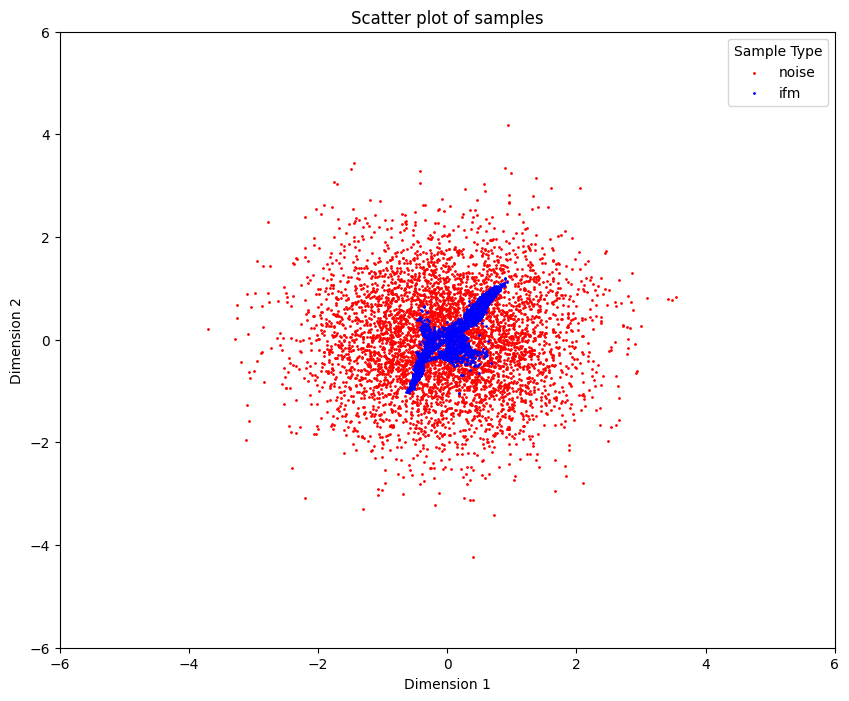

In [86]:
data = input_output_adata.X
# Extract labels for coloring
labels = input_output_adata.obs['sample']

# Map categories to colors
color_map = {'noise': 'red','ifm': 'blue'}
colors = labels.map(color_map)

# Create scatter plot
plt.figure(figsize=(10, 8))
for category, color in color_map.items():
    idx = labels == category
    plt.scatter(data[idx, 0], data[idx, 1], c=color, label=category, alpha=1.0, s=1)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.title('Scatter plot of samples')
plt.legend(title='Sample Type')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


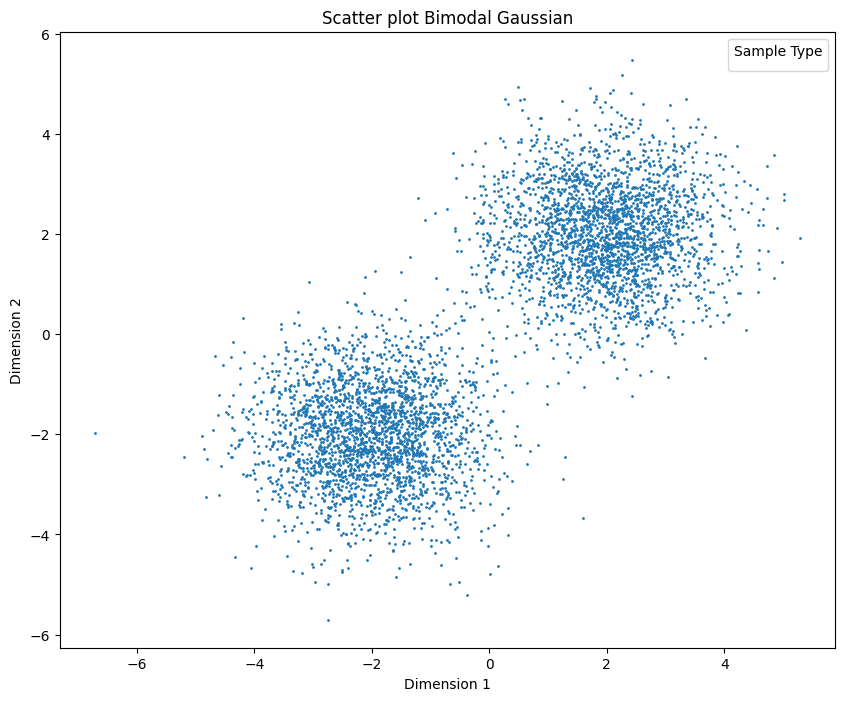

In [12]:
data = generate_bimodal_samples(5000).numpy()

# Create scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(data[:, 0], data[:, 1], alpha=1.0, s=1)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Scatter plot Bimodal Gaussian')
plt.legend(title='Sample Type')
plt.show()

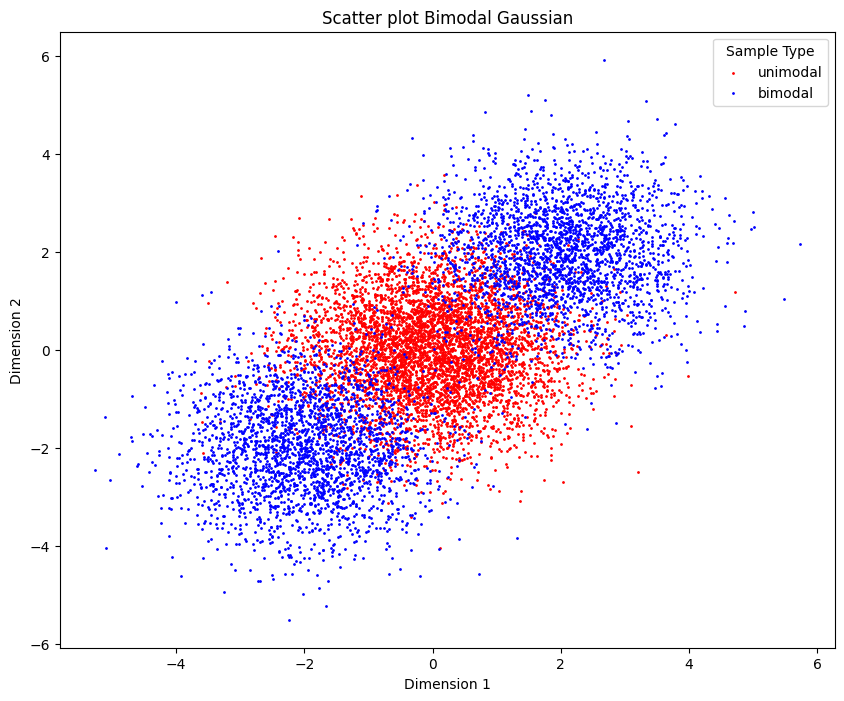

In [18]:
data = generate_bimodal_samples(5000).numpy()

# Create scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(noise[:, 0], noise[:, 1], c='red', alpha=1.0, s=1, label='unimodal')
plt.scatter(data[:, 0], data[:, 1], c='blue', alpha=1.0, s=1, label='bimodal')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Scatter plot Bimodal Gaussian')
plt.legend(title='Sample Type')
plt.show()

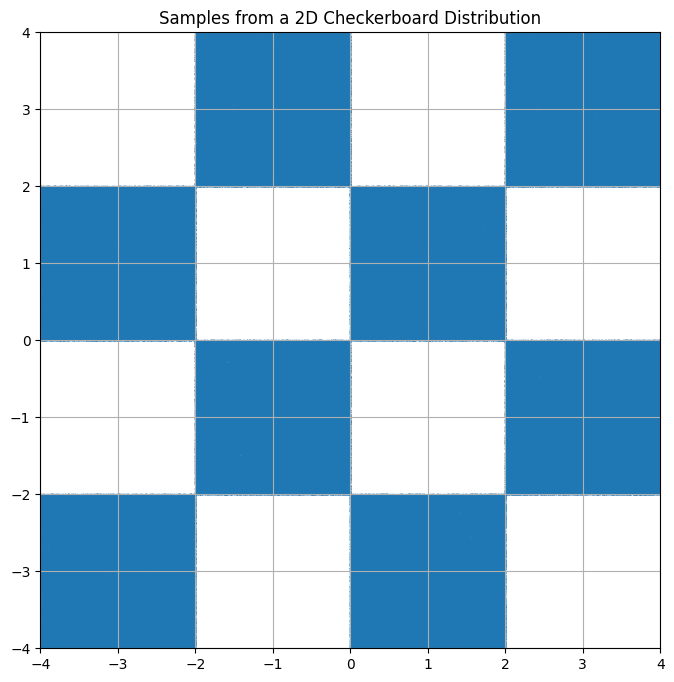

In [119]:
import numpy as np
import matplotlib.pyplot as plt

def generate_checkerboard_samples(num_samples):
    # Initialize array to store samples
    samples = np.zeros((num_samples, 2))
    
    # List of supported squares, each defined by the lower bound corner (x, y)
    supported_squares = []
    for x in range(-4, 4, 2):  # from -4 to 2, stepping by 2
        for y in range(-4, 4, 2):  # from -4 to 2, stepping by 2
            if (x // 2 + y // 2) % 2 == 0:  # checkerboard pattern condition
                supported_squares.append((x, y))
    
    # Generate samples
    for i in range(num_samples):
        # Choose a random square from the supported squares
        square = supported_squares[np.random.randint(len(supported_squares))]
        # Generate a random point within this square
        samples[i, 0] = np.random.uniform(square[0], square[0] + 2)
        samples[i, 1] = np.random.uniform(square[1], square[1] + 2)
    
    return torch.tensor(samples)

# Number of samples to generate
num_samples = 1000000

# Generate samples
samples = generate_checkerboard_samples(num_samples).numpy()

# Plot the samples
plt.figure(figsize=(8, 8))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=0.1)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.title("Samples from a 2D Checkerboard Distribution")
plt.grid(True)
plt.show()


# Single-cell plots

In [76]:
sample_indices = np.random.choice(adata.shape[0], size=batch_size*num_steps, replace=False)

# Subset the AnnData object
sampled_adata = adata[sample_indices]

# Convert to a dense matrix and extract the numpy array
dense_array = sampled_adata.X.toarray() if issparse(sampled_adata.X) else sampled_adata.X

In [77]:
simple_sampled_adata = anndata.AnnData(X=dense_array)
simple_sampled_adata.obs['sample'] = ['train data']*len(simple_sampled_adata)
combined_norm_adata = anndata.concat([simple_sampled_adata, ifm_adata])

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


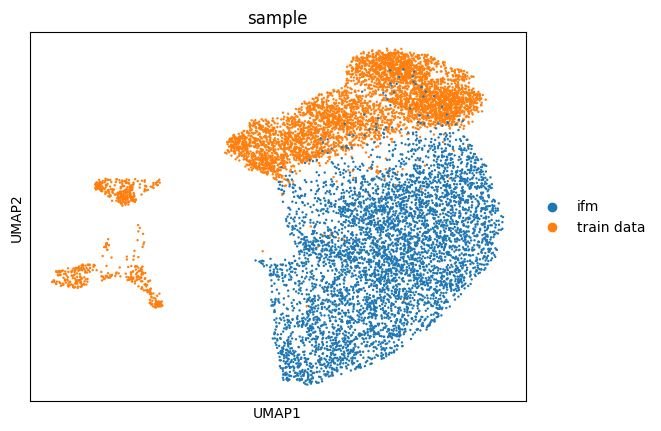

In [78]:
sc.pp.pca(combined_norm_adata)
sc.pp.neighbors(combined_norm_adata)
sc.tl.umap(combined_norm_adata)
sc.pl.umap(combined_norm_adata, color=['sample'], wspace=0.5)

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


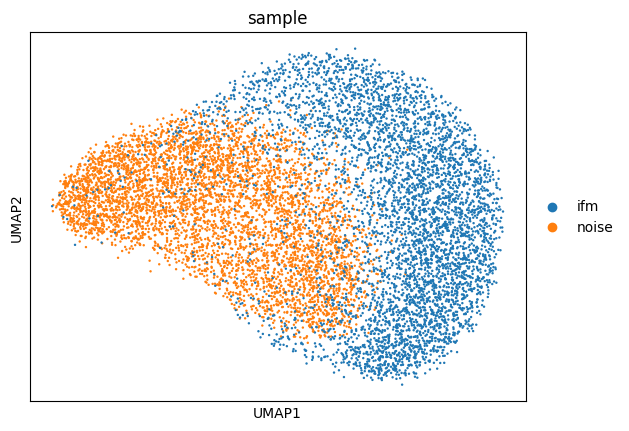

In [13]:
sc.pp.pca(input_output_adata)
sc.pp.neighbors(input_output_adata)
sc.tl.umap(input_output_adata)
sc.pl.umap(input_output_adata, color=['sample'], wspace=0.5)

In [60]:
noise_gen_gt_adata = anndata.concat([simple_sampled_adata, ifm_adata, noise_adata, middle_adata])

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [51]:
# Calculate the mean along the last axis (columns)
mean_row = np.mean(adata.X, axis=0)

# Reshape mean_row to make it a 2D array with one row
mean_row = mean_row.reshape(1, -1)

# Repeat the mean_row for the same number of times as there are rows in the original array
repeated_mean_array = np.repeat(mean_row, dense_array.shape[0], axis=0)

# Generate Gaussian noise with mean 0 and standard deviation 0.1
noise = np.random.normal(0, 0.1, repeated_mean_array.shape)

# Add the noise to the repeated_mean_array
noisy_array = repeated_mean_array + noise

mean_adata = anndata.AnnData(X=noisy_array)
mean_adata.obs['sample'] = ['mean']*len(mean_adata)

combined_mean_ifm_adata = anndata.concat([mean_adata, ifm_adata])


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [52]:
all_adata = anndata.concat([simple_sampled_adata, mean_adata, ifm_adata])

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


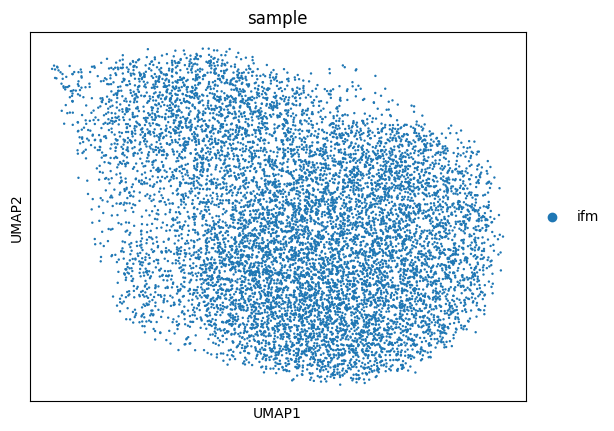

In [12]:
sc.pp.pca(ifm_adata)
sc.pp.neighbors(ifm_adata)
sc.tl.umap(ifm_adata)
sc.pl.umap(ifm_adata, color=['sample'], wspace=0.5)

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


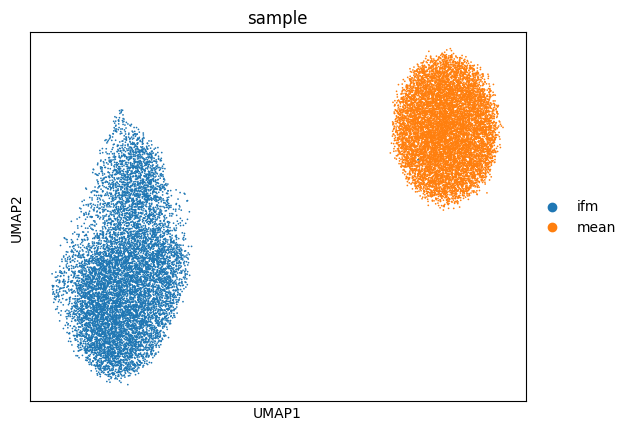

In [13]:
sc.pp.pca(combined_mean_ifm_adata)
sc.pp.neighbors(combined_mean_ifm_adata)
sc.tl.umap(combined_mean_ifm_adata)
sc.pl.umap(combined_mean_ifm_adata, color=['sample'], wspace=0.5)

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


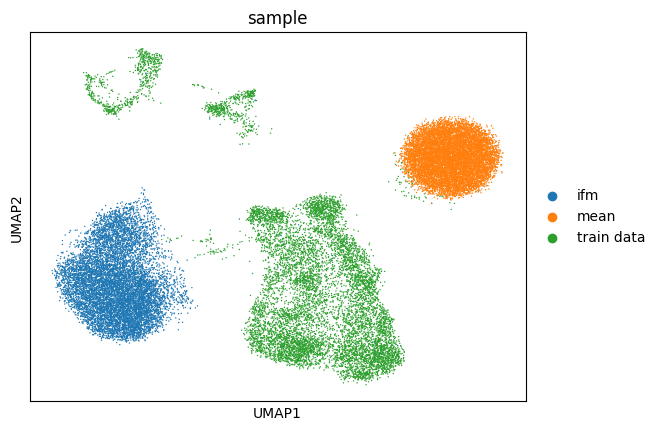

In [14]:
sc.pp.pca(all_adata)
sc.pp.neighbors(all_adata)
sc.tl.umap(all_adata)
sc.pl.umap(all_adata, color=['sample'], wspace=0.5)

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


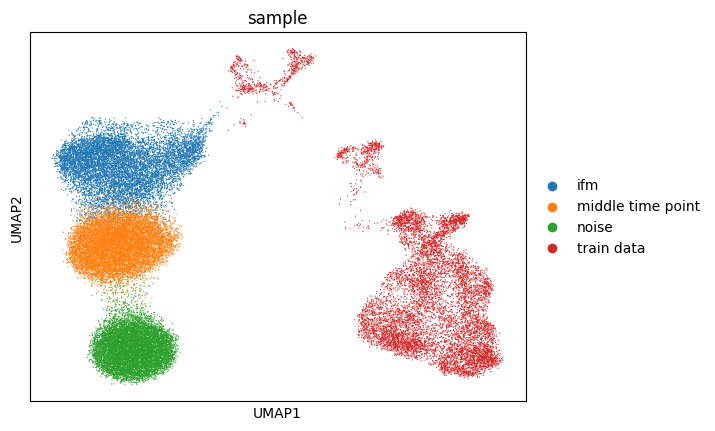

In [23]:
sc.pp.pca(noise_gen_gt_adata)
sc.pp.neighbors(noise_gen_gt_adata)
sc.tl.umap(noise_gen_gt_adata)
sc.pl.umap(noise_gen_gt_adata, color=['sample'], wspace=0.5)